<a href="https://colab.research.google.com/github/Sheepybloke2-0/CSE841-Project/blob/main/gan_art2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN for Creating Color Images from a WikiArt Dataset


In [ ]:
# Check that imports for the rest of the file work.
import tensorflow as tf

!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
!pip install -q kaggle

import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds

from IPython import display

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
from google.colab import files
import pathlib
kaggleJson = pathlib.Path("/content/.kaggle/kaggle.json")
if not kaggleJson.is_file():
  # files.upload()
  !mkdir -p /content/.kaggle/
  %cd /content/gdrive/My\ Drive/
  !cp ./kaggle.json /content/.kaggle/
  !chmod 600 /content/.kaggle/kaggle.json
%env KAGGLE_CONFIG_DIR=/content/.kaggle
!echo $KAGGLE_CONFIG_DIR
!kaggle config view
!kaggle datasets list

/content/gdrive/My Drive
env: KAGGLE_CONFIG_DIR=/content/.kaggle
/content/.kaggle
Configuration values from /content/.kaggle
- username: reubenlewis
- path: None
- proxy: None
- competition: None
ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55           1243  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           3072  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57           1487  
sakshigoyal7/credit-card-customers          

In [4]:
# %cd /content/gdrive/My\ Drive 
# !kaggle datasets download -d ipythonx/wikiart-gangogh-creating-art-gan
# !rm -r /content/trainSet/
# !rm -r /content/testSet/
# artLib = pathlib.Path('/content/gdrive/My Drive/artgenreset.zip')
artLib = pathlib.Path('/content/gdrive/My Drive/wikiart-gangogh-creating-art-gan.zip')
if not artLib.is_file():
  %cd /content/gdrive/My\ Drive/
  # !kaggle datasets download -d parkerzmartin/artgenreset
  !kaggle datasets download -d ipythonx/wikiart-gangogh-creating-art-gan
  !ls
  # !unzip artgenreset.zip
  !unzip wikiart-gangogh-creating-art-gan.zip -d /content/
else:
  %cd /content/gdrive/My\ Drive/
  # !unzip -u artgenreset.zip -d /content/ 
  !unzip wikiart-gangogh-creating-art-gan.zip -d /content/
  # !rm wikiart-gangogh-creating-art-agan.zip
# dataDir = tf.keras.utils.get_file(origin=datasetURL, fname='wikiArt', extract=True)

Streaming output truncated to the last 5000 lines.
  inflating: /content/still-life/55bcc9e1b914c4490f320b65efc91736c.jpg  
  inflating: /content/still-life/560140270766ce421fb8e6fdfc5d649ec.jpg  
  inflating: /content/still-life/562843932429acb8192900b1816d65bcc.jpg  
  inflating: /content/still-life/563e3706fd8258dfc750d91a11ef2cd8c.jpg  
  inflating: /content/still-life/56412c99702c33952475a32c962dcff0c.jpg  
  inflating: /content/still-life/5674ea7a997a3fae603e2cc3844aa808c.jpg  
  inflating: /content/still-life/5675cdb5e9488e298e1686bad3f60b46c.jpg  
  inflating: /content/still-life/567fcef3ee874b44e8bb5066839f581bc.jpg  
  inflating: /content/still-life/56826a3d23df262fca95687eaf755bbac.jpg  
  inflating: /content/still-life/568cc91147ad915386e1a9fcbf58d386c.jpg  
  inflating: /content/still-life/5698d9c5d5b1e40b97e12c46e7675fa7c.jpg  
  inflating: /content/still-life/56a89b5387633ec9df59460f02b53328c.jpg  
  inflating: /content/still-life/56b4b991edfdd88dc9016be3dc2162f2c.jpg  


In [ ]:
# from cv2 import imread
# from os import listdir

# #for filename in listdir('C:/tensorflow/models/research/object_detection/images/train'):
# for dir in listdir('/content/trainSet'):
#   path = os.path.join('/content/trainSet/', dir)
#   for filename in listdir(path):
#     if filename.endswith(".jpg"):
#       print(path+filename)
#       imread(path+filename)
%cd /content/
!rm -r sample_data
# !rm -r wikiart
# !rm -r abstract
# !rm -r animal-painting
# !rm -r cityscape
# !rm -r abstract

/content


In [57]:
rootDir = pathlib.Path('/content/')
%cd /content/
# imageCount = len(list(rootDir.glob('*/*.jpg')))
# imageCount = len(list(rootDir.glob('abstract/*')))
!mkdir -p wikiart
# !mv ./wikiart/portrait/ .
# !mv ./landscape wikiart/
# !mv ./portrait wikiart/
# !mv ./abstract wikiart/
# !mv ./wikiart/portrait ./
imageCount = len(list(rootDir.glob('wikiart/*/*.jpg')))
png = len(list(rootDir.glob('trainSet/*/*.png')))
py = len(list(rootDir.glob('trainSet/*/*.py')))

print(imageCount)
print(png)
print(py)

/content
15894
0
0


In [58]:
# Parameters
# Total number of images
BUFFER_SIZE = imageCount
# Size of images to take and train with
BATCH_SIZE = 256
# BATCH_SIZE = 64
# Number of cycles
EPOCHS = 1000
# im_size = (64, 64)
im_size = (128, 128)
noise_dim = 100
num_examples_to_generate = 16

d_hist, g_hist = list(), list()

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [59]:
# Loads the data in from the real training set
# trainPath = os.path.join(rootDir, 'trainSet')
trainPath = os.path.join(rootDir, 'wikiart')
testPath = os.path.join(rootDir, 'testSet')
trainDataSet = tf.keras.preprocessing.image_dataset_from_directory(
    # rootDir,
    trainPath,
    # validation_split=0.2, # Start with 80/20 split for validation
    # subset="training",
    seed=123,
    image_size=im_size,
    batch_size=BATCH_SIZE
)

# testDataSet = tf.keras.preprocessing.image_dataset_from_directory(
#     trainPath,
#     # rootDir,
#     validation_split=0.0, # Start with 80/20 split for validation
#     subset="validation",
#     seed=123,
#     image_size=im_size,
#     batch_size=BATCH_SIZE
# )

classNames = trainDataSet.class_names
print(classNames)

# Double check that our data is in the correct shape
print(trainDataSet.element_spec)
trainDataSet = trainDataSet.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
trainDataSet.shuffle(buffer_size=BUFFER_SIZE)
trainDataSet = trainDataSet.apply(tf.data.experimental.ignore_errors())

Found 15894 files belonging to 4 classes.
['.ipynb_checkpoints', 'figurative', 'religious-painting', 'symbolic-painting']
(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


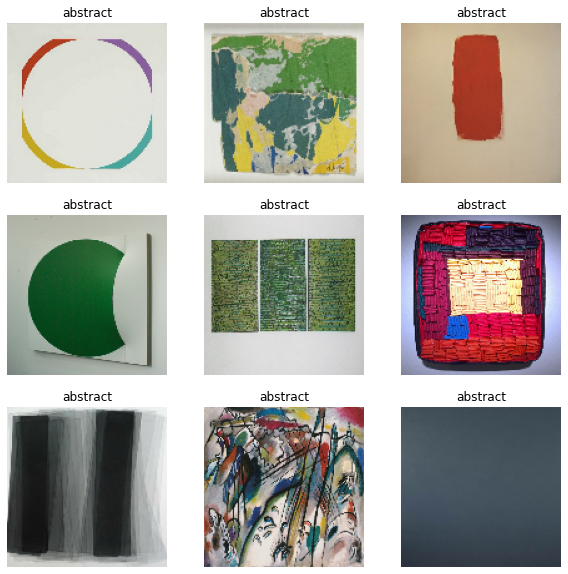

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in trainDataSet.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classNames[labels[i]])
    plt.axis("off")

In [60]:
# Create a layer to scale the images to around [-1, 1]
normLayer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

normTrainDS = trainDataSet.map(lambda x, y: (normLayer(x), y))
normTrainDS.shuffle(BUFFER_SIZE)

print(normTrainDS.element_spec)
img, labels = next(iter(normTrainDS))
first = img[0]
print(np.min(first), np.max(first))

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
-1.0 1.0


In [61]:
def make_generator_model():
    # Using the structure defined here: https://towardsdatascience.com/developing-a-dcgan-model-in-tensorflow-2-0-396bc1a101b2
    # Will upscale for 128x128
    model = tf.keras.Sequential()

    # Create our densely connected layer from the random input data
    model.add(layers.Dense(4*4*1028, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Reshape((4, 4, 1028)))
    assert model.output_shape == (None, 4, 4, 1028) # Note: None is the batch size

    # Upsample and use our model to create an image based on inputs
    model.add(layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
      
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, 128, 128, 3)

    return model


(None, 64, 64, 64)
(None, 128, 128, 3)
tf.Tensor([0.50012404 0.4999866  0.49983996], shape=(3,), dtype=float32)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16448)             1644800   
_________________________________________________________________
batch_normalization_10 (Batc (None, 16448)             65792     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16448)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 1028)        0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 8, 8, 512)         4737024   
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 512)         2048      
________

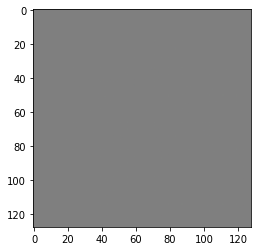

In [62]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image = (generated_image + 1) /2
plt.imshow(generated_image[0] )
print(generated_image[0, 1, 1, :])
generator.summary()

In [63]:
def make_discriminator_model():
    # TODO: maybe have something like 7x7 for kernel size since we're trying to
    # do a larger image, or start with a larger size and shrink the kernels later
    # https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
    model = tf.keras.Sequential()
    # normLayer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
    # model.add(normLayer)
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                    #  input_shape=[64, 64, 3]))
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2)) # Reduce?

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2)) # Reduce?

    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.2)) # Reduce?

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [64]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[0.0085407]], shape=(1, 1), dtype=float32)


In [65]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [66]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [67]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [68]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) # maybe reduce this


In [69]:
%cd /content/gdrive/My\ Drive/

/content/gdrive/My Drive


In [70]:
!mkdir -p relig
%cd ./relig
checkpoint_dir = './'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


/content/gdrive/My Drive/relig


In [71]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # print("Generating Image")
      generated_images = generator(noise, training=True)
      # print(generated_images)
      # print("Checking Image")
      real_output = discriminator(images, training=False)
      # print(real_output)
      fake_output = discriminator(generated_images, training=False)
      # print(fake_output)
      # print("Checking Loss")
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      g_hist.append(gen_loss)
      d_hist.append(disc_loss)
  
    # print("Checking and applying gradients")
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [72]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    dataset.shuffle(BATCH_SIZE)
    
    for image_batch, labels_batch in dataset:
      # print("next image batch")
      train_step(image_batch)
      # print(epoch, d_hist[-1], g_hist[-1] )


    # Produce images for the GIF as we go
    display.clear_output(wait=True)

    # Save the model every 15 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    generate_and_save_images(generator,
                             epoch,
                             seed, 'save')

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed, 'save')
  # plot_history(d_hist, g_hist)


In [73]:
def generate_and_save_images(model, epoch, test_input, save):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  print(predictions.shape)
  predictions = (predictions + 1)/2
  print(predictions[0, 5, 5, :])
  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # plt.imshow(predictions[i, :, :, 1] * 127.5 + 127.5)
      plt.imshow(predictions[i])
      plt.axis('off')
  
  if save == 'save':
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


(16, 128, 128, 3)
tf.Tensor([0.72051626 0.5686109  0.3864814 ], shape=(3,), dtype=float32)


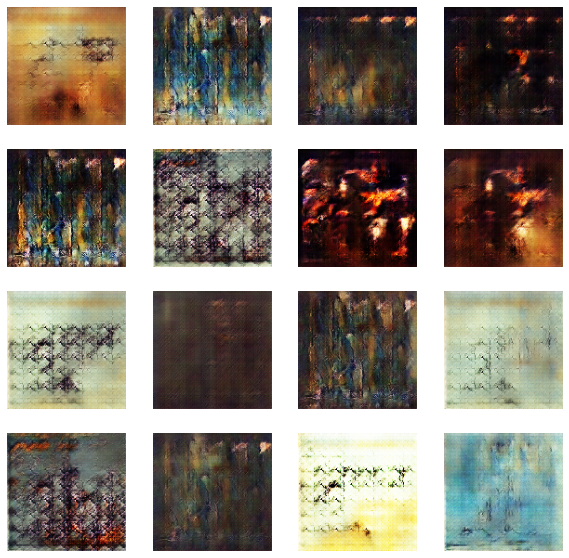

In [74]:
train(normTrainDS, EPOCHS)
# train(trainDataSet, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


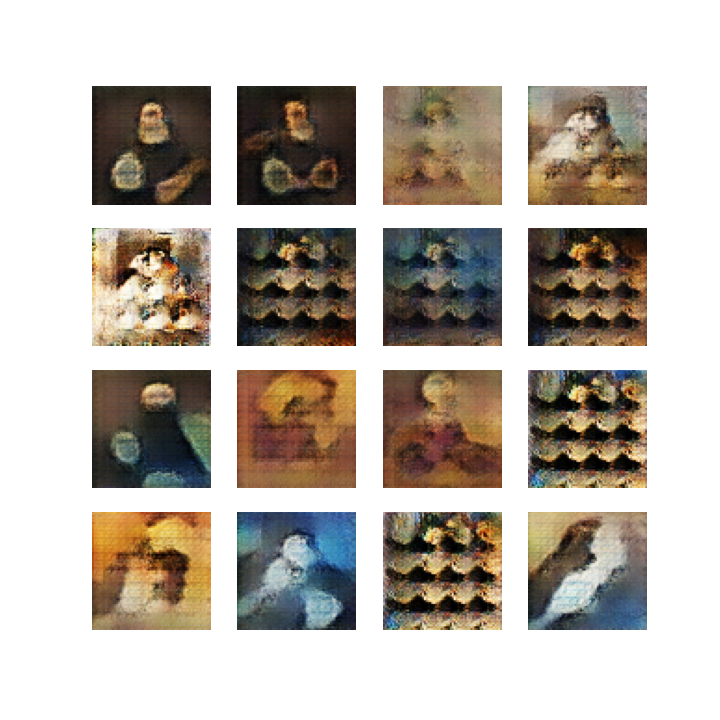

In [ ]:
display_image(EPOCHS)
# display_plot()

(16, 128, 128, 3)
tf.Tensor([0.72051626 0.5686109  0.3864814 ], shape=(3,), dtype=float32)


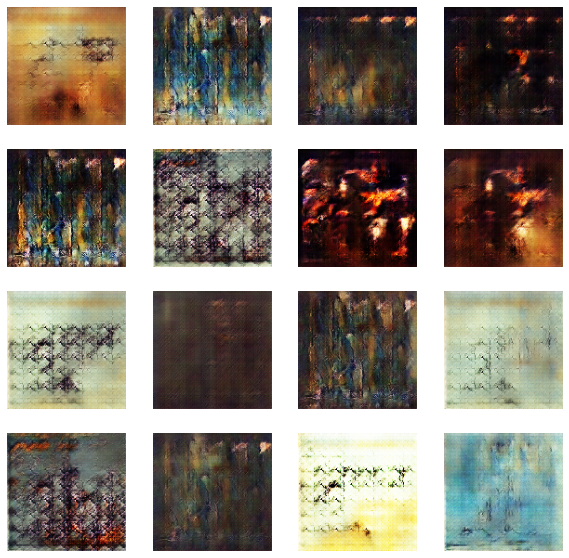

In [75]:
generate_and_save_images(generator, 1001, seed, 'show')

In [76]:
anim_file = 'dcgan-landscape.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


In [56]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)
